Approach/Goal
-----
Using this news article dataset with a little over 10 thousand entries, I was interested in finding if there were any trends among the more popular articles. Maybe the most popular articles were written by the same authors, or published by the same publishers, or published on the same day. Actually, it would be really interesting to see if the most popular articles were written about the same topics. And then, see if there were certain authors or publishers that dominated those topics in order to maximize their visibility and profit. Perhaps, there are some topics that always catch the public eye.


I know finding trends in the topics of the articles would require me to use clustering. I am familiar with the concept, but I have never applied it before now, so this should be a fun learning experience. First, I have to clean and organize the data with <b> pandas</b>. Then, with <b>sklearn</b> and kmeans, I plan to cluster by topic using the title, description, or content attributes. With the clusters, I can find the top authors/publishers and the average Facebook reactions, comments, and shares with aggregate functions. From there, I can be flexible with other observations and how I present the data.


In [119]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import nltk 
import re
import os
import codecs
from sklearn import feature_extraction
import sys
print(sys.executable)
!/usr/bin/python3 -m pip install wordcloud
from wordcloud import WordCloud

/usr/bin/python3
  Using cached wordcloud-1.8.1-cp38-cp38-manylinux1_x86_64.whl (371 kB)
  Using cached numpy-1.21.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.8 MB)
  Using cached matplotlib-3.4.3-cp38-cp38-manylinux1_x86_64.whl (10.3 MB)
  Using cached Pillow-8.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Using cached kiwisolver-1.3.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
tensorflow 2.4.1 requires six~=1.15.0, but you h

Cleaning the data
----------------------------

In [23]:
df = pd.read_csv('news_articles.csv', index_col=0)
df=df.sort_values(by=["engagement_reaction_count"],ascending=False)
df.head()
# I'm ordering by reaction count because when I remove duplicates, I want to keep the article with the most reactions.

,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
8500,cnn,CNN,Elizabeth Wolfe And Brian Ries,"Jimmy Carter, the oldest living former U.S. pr...","Jimmy Carter, the oldest living former U.S. pr...",https://www.cnn.com/2019/10/01/us/jimmy-carter...,https://cdn.cnn.com/cnnnext/dam/assets/1909241...,2019-10-01T10:40:23Z,NaN,0.0,354132.0,41293.0,39422.0,8.0
2075,bbc-news,BBC News,BBC News,Zimbabwe ex-President Robert Mugabe dies aged 95,"Robert Mugabe, Zimbabwe's first post-independe...",http://www.bbc.co.uk/news/world-africa-49604152,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-06T05:04:07Z,"Robert Mugabe, Zimbabwe's first post-independe...",1.0,125106.0,48490.0,32921.0,0.0
8834,abc-news,ABC News,Bill Hutchinson,Amber Guyger convicted of murder in wrong-apar...,Amber Guyger convicted of murder in wrong-apar...,https://abcnews.go.com/US/amber-guyger-convict...,https://s.abcnews.com/images/US/guyger-1-ap-er...,2019-10-01T15:48:31Z,A Texas jury rejected former Dallas police off...,0.0,91311.0,20128.0,22080.0,0.0
5092,the-new-york-times,The New York Times,Coral Davenport,Trump Administration to Finalize Rollback of C...,The administration is expected to complete the...,https://www.nytimes.com/2019/09/12/climate/tru...,https://static01.nyt.com/images/2018/12/11/cli...,2019-09-12T13:19:36Z,"The repeal of the water rule, which is schedul...",0.0,66910.0,15234.0,24519.0,0.0
225,bbc-news,BBC News,https://www.facebook.com/bbcnews,Brexit: Tory MP defects ahead of crucial no de...,Phillip Lee's move leaves Boris Johnson with n...,https://www.bbc.co.uk/news/uk-politics-49570682,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:48:14Z,Conservative MP Philip Lee has defected to the...,0.0,60117.0,19043.0,10752.0,0.0


In [39]:
#I notice there are some duplicates. I think it's best to cluster the articles by description,
# since the description, by definition, would best represent the article. I notice ABC News uses the 
# same description every time, so for these cases or when the description is NaN, I'll set the title or content 
# (I think title might be better) to be the new description. Then I'll be able to drop the dupplicates.
for index, row in df.iterrows():
    if ((df.at[index,"source_name"]=="ABC News") or pd.isna(df.at[index,"description"])):
        df.at[index,"description"]=df.at[index,"title"]
    if pd.isna(df.at[index,"description"]):
        df.at[index,"description"]=df.at[index,"content"]

In [41]:
df=df.drop_duplicates(subset=['description'], keep="first")

In [108]:
articles= pd.DataFrame(df, columns = ['title', 'description',"engagement_reaction_count", "engagement_comment_count", "engagement_share_count", "author", "source_name"])
articles

,title,description,engagement_reaction_count,engagement_comment_count,engagement_share_count,author,source_name
8500,"Jimmy Carter, the oldest living former U.S. pr...","Jimmy Carter, the oldest living former U.S. pr...",354132.0,41293.0,39422.0,Elizabeth Wolfe And Brian Ries,CNN
2075,Zimbabwe ex-President Robert Mugabe dies aged 95,"Robert Mugabe, Zimbabwe's first post-independe...",125106.0,48490.0,32921.0,BBC News,BBC News
8834,Amber Guyger convicted of murder in wrong-apar...,Amber Guyger convicted of murder in wrong-apar...,91311.0,20128.0,22080.0,Bill Hutchinson,ABC News
5092,Trump Administration to Finalize Rollback of C...,The administration is expected to complete the...,66910.0,15234.0,24519.0,Coral Davenport,The New York Times
225,Brexit: Tory MP defects ahead of crucial no de...,Phillip Lee's move leaves Boris Johnson with n...,60117.0,19043.0,10752.0,https://www.facebook.com/bbcnews,BBC News
...,...,...,...,...,...,...,...
9158,Subscriber Only: ‘My Irish fiance thinks my fa...,Tell Me About it: He is shocked by my politica...,NaN,NaN,NaN,The Irish Times,The Irish Times
9528,Weather warnings issued ahead of Storm Lorenzo...,Torrential rain and gusts of more than 130km/h...,NaN,NaN,NaN,"Ronan McGreevy, Vivienne Clarke",The Irish Times
10019,Subscriber Only: Why is Boris Johnson giving i...,DUP support seen as crucial to keeping hard Br...,NaN,NaN,NaN,The Irish Times,The Irish Times
10244,Fancy having tea with a ‘naughty sheep’? New A...,"Airbnb, best known for its accommodation shari...",NaN,NaN,NaN,Conor Pope,The Irish Times


Clustering
--------------------------
We are going to start counting and normalizing all words in every article to find the most frequent words. This will help us get an idea of the main topics for every article.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer  
    
# This is removing unnecessary words like "the", "and", and a lot more. Words like these don't contribute to our 
# clustering so we remove them.
tfidf_vectorizer=TfidfVectorizer(stop_words="english")
tfidf_vectorizer_vectors= tfidf_vectorizer.fit_transform(articles['description'].values.astype('U'))

In [28]:
print(tfidf_vectorizer_vectors.shape)

(9588, 20826)


In [29]:
# By changing articleNum, you can use this to find the most frequent words in a specific article. Pretty cool. 
# The frequency values are vectors used for our kmeans clustering
articleNum=5511
wordcount = pd.DataFrame(tfidf_vectorizer_vectors[articleNum].T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
wordcount.sort_values(by=["tfidf"],ascending=False).head()

,tfidf
sprinter,0.334197
coleman,0.325705
athletics,0.299328
tests,0.295701
missed,0.289344


This next part is called the Elbow Method. It is used to find k, or the ideal amount of clusters in kmeans. The amount of clusters can greatly affect the results, so it's important we choose the correct k. In the graph below, it looks like k should be 8.


In [53]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf_vectorizer_vectors= tfidf.fit_transform(articles['description'].values.astype('U'))

In [65]:
def find_optimal_clusters(articles, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=2000, batch_size=1000, random_state=20).fit(articles).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters


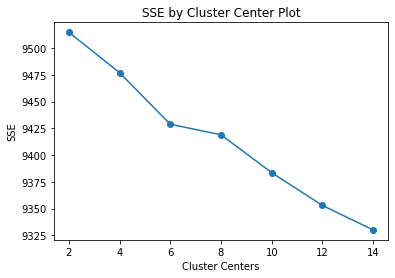

In [56]:
find_optimal_clusters(tfidf_vectorizer_vectors, 15)

I wanted to plot the vectors to test if setting k to 8 was the best option. I tried a variety of options from 4 to 24 (not all are included), but it looks like 8 was the best. I know the results also depend on the values of init_size and  batch_size, but I was having a hard time picking those. There are other ways to find the best k, like the Silhoutte coefficient, but I didn't have much luck trying that either.

In [57]:
def plot_tsne_pca(articles, labels):
    data=articles
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')


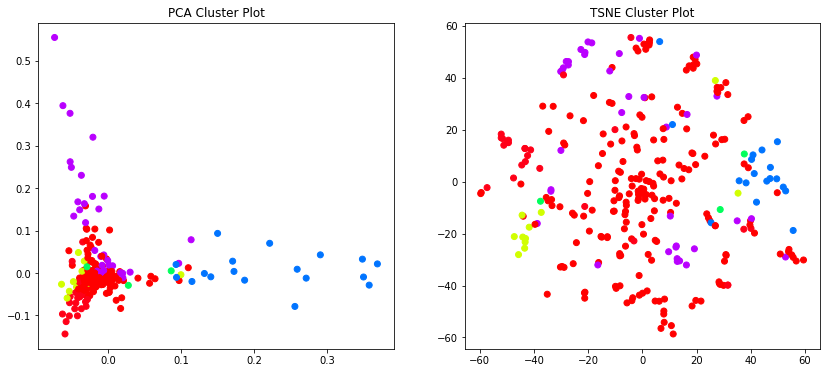

In [58]:
clusters = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_vectorizer_vectors)
plot_tsne_pca(tfidf_vectorizer_vectors, clusters)


This plot with 6 clusters, does have good separation, but I feel like the red cluster may be too much.

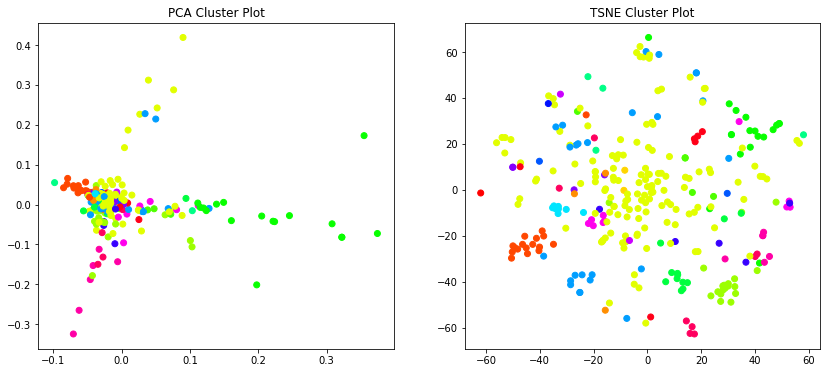

In [59]:
clusters = MiniBatchKMeans(n_clusters=22, init_size=2000, batch_size=1000, random_state=20).fit_predict(tfidf_vectorizer_vectors)
plot_tsne_pca(tfidf_vectorizer_vectors, clusters)


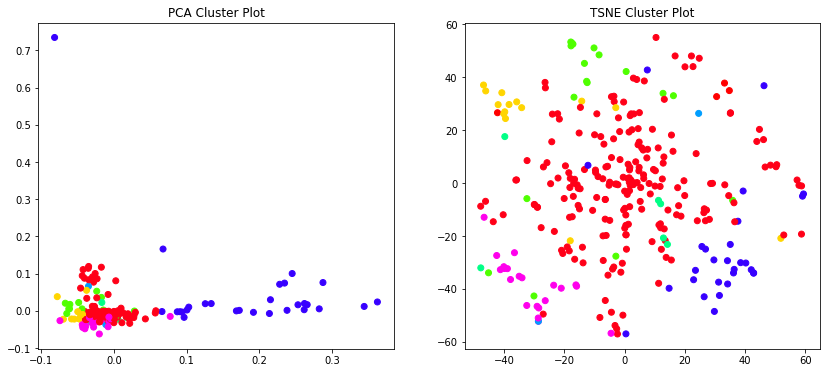

In [69]:
clusters = MiniBatchKMeans(n_clusters=8, init_size=2000, batch_size=1000, random_state=20).fit_predict(tfidf_vectorizer_vectors)
plot_tsne_pca(tfidf_vectorizer_vectors, clusters)


For some reason the above code to make those plots messes up my clusters, so we need to define clusters again with...

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters


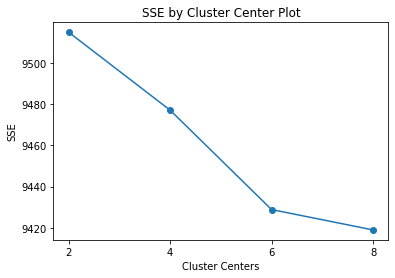

In [80]:
find_optimal_clusters(tfidf_vectorizer_vectors, 8)

In [81]:
# Above, on the right plot, I think you can pretty clearly see 5 of the 8 clusters. Each dot should be an article,
# and the color is the cluster it was assigned. The plots for other values of k weren't this clear.

# Here, the table allows us to see the cluster that each article was assigned.
true_k = 8
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(tfidf_vectorizer_vectors)
labels=model.labels_
clusters=pd.DataFrame(list(zip(articles["title"], articles["description"],labels)),columns=['title',"description",'cluster'])
clusters

,title,description,cluster
0,"Jimmy Carter, the oldest living former U.S. pr...","Jimmy Carter, the oldest living former U.S. pr...",7
1,Zimbabwe ex-President Robert Mugabe dies aged 95,"Robert Mugabe, Zimbabwe's first post-independe...",0
2,Amber Guyger convicted of murder in wrong-apar...,Amber Guyger convicted of murder in wrong-apar...,0
3,Trump Administration to Finalize Rollback of C...,The administration is expected to complete the...,0
4,Brexit: Tory MP defects ahead of crucial no de...,Phillip Lee's move leaves Boris Johnson with n...,3
...,...,...,...
9583,Subscriber Only: ‘My Irish fiance thinks my fa...,Tell Me About it: He is shocked by my politica...,0
9584,Weather warnings issued ahead of Storm Lorenzo...,Torrential rain and gusts of more than 130km/h...,0
9585,Subscriber Only: Why is Boris Johnson giving i...,DUP support seen as crucial to keeping hard Br...,0
9586,Fancy having tea with a ‘naughty sheep’? New A...,"Airbnb, best known for its accommodation shari...",4


In [86]:
savedCluster=clusters.copy(deep=True)

When the articles are grouped by clusters, something really cool happens. You can start to see patterns.
Just by glancing at some of the titles and descriptions below, you can see that....

It's important to remember that kmeans, depending on the settings, can have different outputs. So the amount of articles in each cluster will vary, and therefore so will the exact articles and frequencies.
   
   - Cluster 0 with 6628 articles seems to focus on tradegy with mentions of murder, death, and injury.   
   -  Cluster 1 with 490 articles looks a little less straightforward, but I notice a lot of numerical values in the titles, like ages and monetary amounts. This might have caused this cluster to focus on age and the youth.
   - Cluster 2 with 666 articles looks like it has mixed topics. I don't see a clear trend. 
   - Cluster 3 with 284 articles focuses on international events, which I noticed by the mentions of prime ministers and other countries.
   - Cluster 4 with 446 articles looks mixed, but I mostly see mentions of politics and international pop culture like "Census Bureau" and "World Cup".
   - Cluster 5 with 241 articles mentions some natural disasters like "Hurrican Dorian" and "flooding".
   - Cluster 6 with 142 articles clearly focuses on Saudi Arabia and oil.
   - Cluster 7 with 671 articles seems to be about American politics, referencing the branches of government like past presidents, the House of Representatives, the Supreme Court, etc.

In [87]:
for i in range(8):
    print(savedCluster[savedCluster["cluster"]==i])

                                                  title  \
1      Zimbabwe ex-President Robert Mugabe dies aged 95   
2     Amber Guyger convicted of murder in wrong-apar...   
3     Trump Administration to Finalize Rollback of C...   
7     Amber Guyger, Former Dallas Officer, Found Gui...   
8     These 2 women are the first sisters ever to be...   
...                                                 ...   
9582  Anger and shock in Hong Kong in aftermath of v...   
9583  Subscriber Only: ‘My Irish fiance thinks my fa...   
9584  Weather warnings issued ahead of Storm Lorenzo...   
9585  Subscriber Only: Why is Boris Johnson giving i...   
9587  Coastal flooding a ‘certainty’ when Storm Lore...   

                                            description  cluster  
1     Robert Mugabe, Zimbabwe's first post-independe...        0  
2     Amber Guyger convicted of murder in wrong-apar...        0  
3     The administration is expected to complete the...        0  
7     Amber Guyger, For

I thought it would be cool to visualize the cluster topics with word clouds. So here's a word cloud for each topic, with the size correlating to frequency. Some of them confirm my original first impressions, some of them give me a little more insight into the topics. Clusters 0, 1, 2, and 4 are more miscellaneous than I thought. From these wordclouds, I can tell words like "say" or "year" screwed my results as they don't provide much substance to the clustering.

Cluster: 0


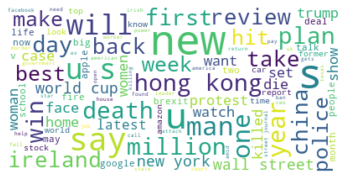

Cluster: 1


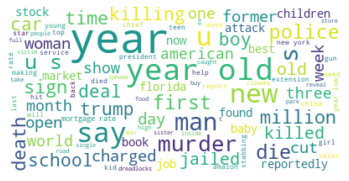

Cluster: 2


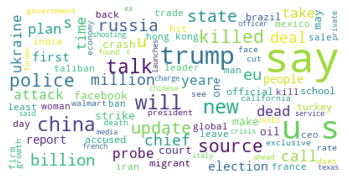

Cluster: 3


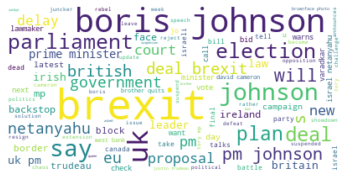

Cluster: 4


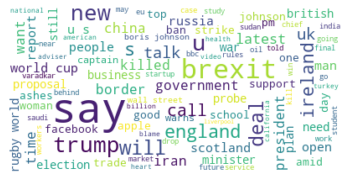

Cluster: 5


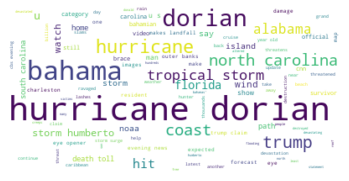

Cluster: 6


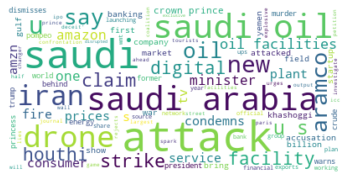

Cluster: 7


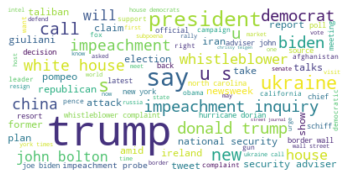

In [88]:
result=savedCluster
for k in range(0,true_k):
    s=result[result["cluster"]==k]
    text=s['title'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    titles=result[result["cluster"]==k]['title']
    #print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Time to check the stats in each cluster!

In [122]:
result=pd.merge(articles, savedCluster, on="description")
result.head()

,title_x,description,engagement_reaction_count,engagement_comment_count,engagement_share_count,author,source_name,title_y,cluster
0,"Jimmy Carter, the oldest living former U.S. pr...","Jimmy Carter, the oldest living former U.S. pr...",354132.0,41293.0,39422.0,Elizabeth Wolfe And Brian Ries,CNN,"Jimmy Carter, the oldest living former U.S. pr...",7
1,Zimbabwe ex-President Robert Mugabe dies aged 95,"Robert Mugabe, Zimbabwe's first post-independe...",125106.0,48490.0,32921.0,BBC News,BBC News,Zimbabwe ex-President Robert Mugabe dies aged 95,0
2,Amber Guyger convicted of murder in wrong-apar...,Amber Guyger convicted of murder in wrong-apar...,91311.0,20128.0,22080.0,Bill Hutchinson,ABC News,Amber Guyger convicted of murder in wrong-apar...,0
3,Trump Administration to Finalize Rollback of C...,The administration is expected to complete the...,66910.0,15234.0,24519.0,Coral Davenport,The New York Times,Trump Administration to Finalize Rollback of C...,0
4,Brexit: Tory MP defects ahead of crucial no de...,Phillip Lee's move leaves Boris Johnson with n...,60117.0,19043.0,10752.0,https://www.facebook.com/bbcnews,BBC News,Brexit: Tory MP defects ahead of crucial no de...,3


Text(0.5, 1.0, 'Average Facebook Engagement by Topic Clusters')

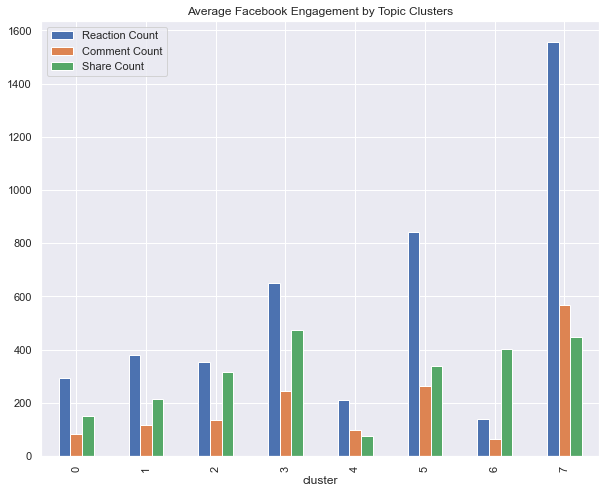

In [191]:
facebookMeans=result.groupby(["cluster"]).mean()
facebookMeans.columns=["Reaction Count", "Comment Count", "Share Count" ]
sns.set_palette("Paired")
sns.set(rc={'figure.figsize':(10,8)})
facebookMeans.plot(kind="bar").set_title('Average Facebook Engagement by Topic Clusters')

This shows that generally there's more reactions than comments or shares. 
- However, Cluster 7, which focuses on politics and Donald Trump according to the wordcloud, has an abnormally high reaction count. 
- Cluster 6, which focuses on Saudi Arabia and oil, has more average shares than it's average reactions. The avearge reactions is low.
- Cluster 4, which roughly focuses on international events, also has low average reactions, shares, and comments.
- The remaining clusters, some of which do focus on international events according to the wordclouds, have average engagement counts in the range of 100 to 800. I think the drastic differences between Cluster 7 and Cluster 6 can be attributed to how people, mainly Americans, view American politics compared to the politics of the Middle East. 

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Distribution of Popular Articles over the Clusters')

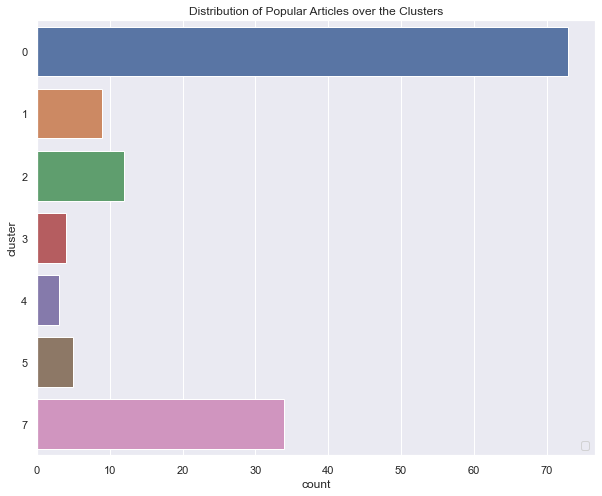

In [228]:
temp=result[:140]
sns.set_palette("hls")
sns.set(rc={'figure.figsize':(10,8)})
plt.legend(loc='lower right')
sns.countplot(y="cluster", data=temp).set_title('Distribution of Popular Articles over the Clusters')

I thought it would be interesting to see how the top 140 articles distributed into the clusters. 
- It looks like Cluster 0, which has miscellaneous topics, has about 74 articles, more than half of the top 140. However, since Cluster 0 has a total of 6000+ articles and the topics are miscellaneous, we can conclude that there isn't an overall theme. Looking at the previous kMeans plot, these would be the red dots. We can't draw much of conclusion from this since it's so vague.
- Clusters 1, 2, 3, 4, and 5 have somewhere from 4 to 12 articles within the top 140 articles. These cluster topics pertain to international matters, politics and natural disasters. They have an average popularity.
- Cluster 6, which focuses on Saudi Arabia and oil, has no articles in the top 140 articles. This is somewhat surprising since oil is a limited resource that is in demand, but perhaps people don't think about it day-to-day.
- Cluster 7, which revolves around American politics and Trump, has about 34 articles within the top 140 articles. This isn't surprising considering the context of when these articles were published. Late 2019 was when American presidential candidates were campaigning. This shows popularity has a lot to do with relevancy of the time.

In [224]:
temp=result[:50]
temp.sort_values(by="author")

# There isn't an individual author that has multiple articles within the top 50 articles. It seemed pretty pointless 
# to make a visual for this. However, this does mean that there isn't a best author. It also shows that specific authors 
# aren't necessarily correlated to popularity (with respect to Facebook reactions).

,title_x,description,engagement_reaction_count,engagement_comment_count,engagement_share_count,author,source_name,title_y,cluster
21,"Trump Is ‘Last Hope for White People,’ Said Po...","The former chief, accused of a hate crime afte...",28670.0,6527.0,5439.0,Andrea Salcedo,The New York Times,"Trump Is ‘Last Hope for White People,’ Said Po...",2
18,MPs return ahead of key Brexit vote,Latest reaction as Prime Minister Boris Johnso...,34137.0,15261.0,36720.0,BBC News,BBC News,MPs return ahead of key Brexit vote,3
1,Zimbabwe ex-President Robert Mugabe dies aged 95,"Robert Mugabe, Zimbabwe's first post-independe...",125106.0,48490.0,32921.0,BBC News,BBC News,Zimbabwe ex-President Robert Mugabe dies aged 95,0
40,Teenager 'blind' from living off crisps and chips,Years of fussy eating left the Bristol 17-year...,15260.0,12545.0,10891.0,BBC News,BBC News,Teenager 'blind' from living off crisps and chips,1
10,PM's brother quits as Tory MP and minister,"Jo Johnson, younger brother of Boris Johnson, ...",41951.0,13287.0,10891.0,BBC News,BBC News,PM's brother quits as Tory MP and minister,3
45,US Open 2019: Rafael Nadal beats Daniil Medved...,Rafael Nadal wins his 19th Grand Slam title af...,14265.0,803.0,1044.0,BBC Sport,BBC News,US Open 2019: Rafael Nadal beats Daniil Medved...,0
25,Trump sacks national security adviser John Bolton,President Trump says he disagreed with many of...,24242.0,10241.0,6271.0,Bbc News,BBC News,Trump sacks national security adviser John Bolton,7
2,Amber Guyger convicted of murder in wrong-apar...,Amber Guyger convicted of murder in wrong-apar...,91311.0,20128.0,22080.0,Bill Hutchinson,ABC News,Amber Guyger convicted of murder in wrong-apar...,0
34,John Bolton fired by Donald Trump today – live...,"President Trump wrote on Twitter that he ""disa...",17866.0,8111.0,4240.0,CBS News,CBS News,John Bolton fired by Donald Trump today – live...,7
36,How we have failed our teachers,Since 1996 inflation-adjusted pay for public s...,16761.0,4388.0,6312.0,CBS News,CBS News,How we have failed our teachers,0


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Popular Articles by Publishers Count, Grouped by Cluster ')

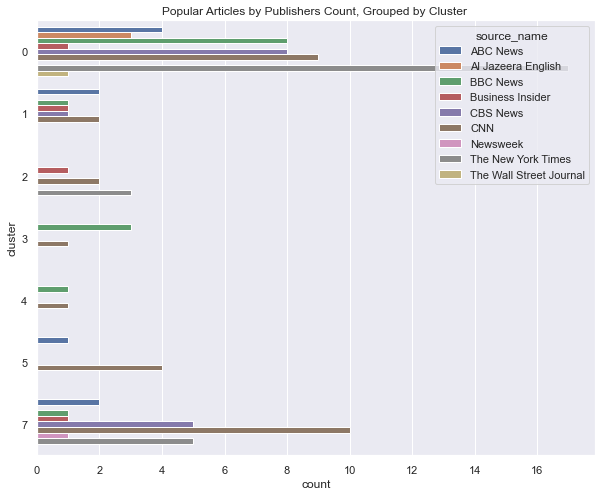

In [206]:
temp=result[:100]
# 100 articles with the most Facebook reactions, which makes them the most popular, since reactions are more
# common than shares or comments.
sns.set_palette("hls")
sns.set(rc={'figure.figsize':(10,8)})
plt.legend(loc='lower right')
sns.countplot(y="cluster", data=temp.sort_values(by="source_name"), hue="source_name").set_title('Popular Articles by Publishers Count, Grouped by Cluster ')

This shows most of these publishers publish articles of different topics, but New York Times dominates with 17 top articles of Cluster 0, which is miscellaneous topics according to the word cloud. CNN dominates the top articles of Cluster 7, which is American politics and Donald Trump. It is also interesting to point out CNN has a top article in every cluster, except for Cluster 6, which has no top 100 articles, with respect to Facebook reactions. This is consistent with our previous analysis that Cluster 6 articles, which focus on Saudi Arabia and oil, get a below average amount of engagement.

Conclusion
---------

Since I was able to cluster this dataset of news articles by topic with kMeans, I was able to see the topics of interest in late 2019. There were 8 clusters for the topics of the articles: Miscellaneous (which was the bulk of the dataset), Violence (not very strong), Crime (not very strong), Brexit (strong), International Politics (somewhat strong), Natural Disasters (strong), Saudi Arabia (strong), American Politics (strong). Although some categories are very specific, I think there's room for improvement. In the future, I would try to modify the kMeans and Elbow Method parameters to get more effective results. I would also add more words like "year" and "say" to the stopwords list so they don't skew the clustering.



After clustering, I defined popularity of an article by its amount of Facebook reactions. Then, I looked for factors that might contribute to article popularity, including topic (by clusters), author, and publisher. It looks like topic, specifically relevant (time-appropriate) and favorable-by-America topics like the presidential election, become popular. It's possible Saudi Arabia isn't a popular cluster because of how Americans view the Middle East. Perhaps sentiment analysis on comment in the future could confirm that. Other observations are that authors don't affect popularity, but publishers do.


Why would this be important? News articles like these are a part of media. Media has the power to tell a narrative and expose the public to new ideas. Analysis like this to see which factors contribute to the popularity of an article may help a writer or journalist priortize certain aspects like publisher or timely and revelant topics to increase the visibility of their article. It would provide the power to have their stories be heard.

Since this was my first time implementing kMeans, I had to refer to a lot of articles.

Sources:

https://github.com/dpanagop/ML_and_AI_examples/blob/master/NLP_example_clustering.ipynb

https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YTGK7_eSnIU

https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0